# It's Corn (PogChamps \#3) Kaggle Competition - Experiment 1

Following along with fast.ai lecture [First Steps: Road to the Top, Part 1](https://www.kaggle.com/code/jhoward/first-steps-road-to-the-top-part-1) with tweaks along the way.

## Setup Competition Files

In [2]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

In [3]:
comp = 'kaggle-pog-series-s01e03'

In [4]:
path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')


In [5]:
path

Path('kaggle-pog-series-s01e03')

In [6]:
import timm
from fastai.vision.all import *
set_seed(42)

path.ls()

(#1) [Path('kaggle-pog-series-s01e03/corn')]

In [7]:
trn_path = path/'corn'/'train'
trn_path.ls()

(#14322) [Path('kaggle-pog-series-s01e03/corn/train/08602.png'),Path('kaggle-pog-series-s01e03/corn/train/06377.png'),Path('kaggle-pog-series-s01e03/corn/train/12836.png'),Path('kaggle-pog-series-s01e03/corn/train/05256.png'),Path('kaggle-pog-series-s01e03/corn/train/03056.png'),Path('kaggle-pog-series-s01e03/corn/train/00938.png'),Path('kaggle-pog-series-s01e03/corn/train/02865.png'),Path('kaggle-pog-series-s01e03/corn/train/02323.png'),Path('kaggle-pog-series-s01e03/corn/train/09385.png'),Path('kaggle-pog-series-s01e03/corn/train/10855.png')...]

In [8]:
tst_path = path/'corn'/'test'
tst_path.ls()

(#3479) [Path('kaggle-pog-series-s01e03/corn/test/02921.png'),Path('kaggle-pog-series-s01e03/corn/test/17570.png'),Path('kaggle-pog-series-s01e03/corn/test/01816.png'),Path('kaggle-pog-series-s01e03/corn/test/07985.png'),Path('kaggle-pog-series-s01e03/corn/test/04347.png'),Path('kaggle-pog-series-s01e03/corn/test/02109.png'),Path('kaggle-pog-series-s01e03/corn/test/09175.png'),Path('kaggle-pog-series-s01e03/corn/test/01604.png'),Path('kaggle-pog-series-s01e03/corn/test/14128.png'),Path('kaggle-pog-series-s01e03/corn/test/01616.png')...]

Grab csv lists

In [9]:
csv_path = path/'corn'
train_csv_fname = csv_path/'train.csv'
train = pd.read_csv(train_csv_fname)
test_csv_fname = csv_path/'test.csv'
test = pd.read_csv(test_csv_fname)
ss_csv_fname = csv_path/'sample_submission.csv'
ss = pd.read_csv(ss_csv_fname)

In [10]:
print(train.head())

   seed_id    view            image       label
0        0     top  train/00000.png      broken
1        1  bottom  train/00001.png        pure
2        3     top  train/00003.png      broken
3        4     top  train/00004.png        pure
4        5     top  train/00005.png  discolored


In [11]:
train['label'].value_counts()

pure          5837
broken        4554
discolored    2504
silkcut       1427
Name: label, dtype: int64

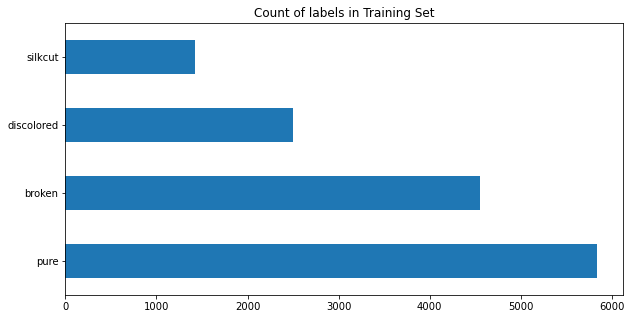

In [12]:
train['label'].value_counts() \
    .plot(kind='barh',
          figsize=(10,5),
          title='Count of labels in Training Set')
plt.show()

## Looking at the data

In [13]:
files = get_image_files(trn_path)

(140, 140)


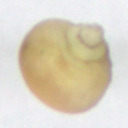

In [14]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

## Check image sizes
Check all the image sizes.  This is faster in parallel.  Using fastcore's `parallel` for this:

In [15]:
print (f"Total number of train images: {len(files)}")

Total number of train images: 14322


In [16]:
from fastcore.parallel import *

def f(o): return PILImage.create(o).size
# AMD Ryzen 9 5900X 12-Cores / 24-Threads
sizes = parallel(f, files, n_workers=24)
pd.Series(sizes).value_counts()

(132, 132)    187
(140, 136)    187
(136, 132)    168
(136, 136)    166
(128, 132)    165
             ... 
(136, 121)      1
(140, 104)      1
(208, 168)      1
(104, 180)      1
(204, 164)      1
Length: 784, dtype: int64

In [17]:
#help(ImageDataLoaders)

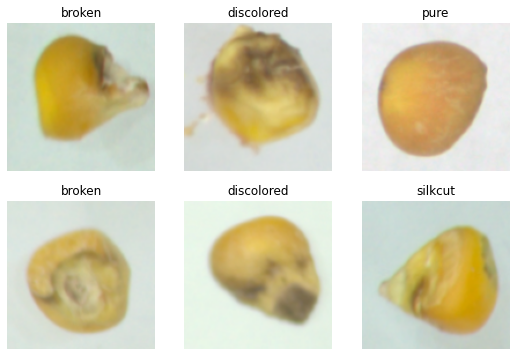

In [18]:
dls = ImageDataLoaders.from_csv(csv_path, 
    csv_fname='train.csv', valid_pct=0.2, seed=42,
    fn_col=2, label_col=3,
    item_tfms=Resize(128, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75))

dls.show_batch(max_n=6)

## First Model

For a first architecture we can start with resnet26d (how to find out what this was pretrained on)?  This architecture seems to be the fastest resolution-independent model which gets into the top 15 lists in [the best vision models for fine-tuning](https://www.kaggle.com/code/jhoward/the-best-vision-models-for-fine-tuning).

In [19]:
learn = vision_learner(dls, 'resnet26d', metrics=accuracy, path='.').to_fp16()

Check the learning rate finder:

SuggestedLRs(valley=0.002511886414140463, slide=0.007585775572806597)

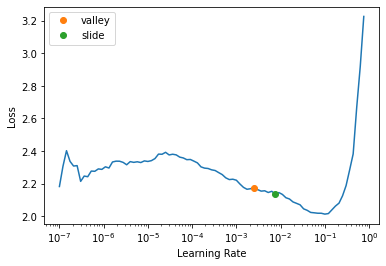

In [20]:
learn.lr_find(suggest_funcs=(valley,slide))

In [21]:
learn.fine_tune(6, 0.007)

epoch,train_loss,valid_loss,accuracy,time
0,1.120331,1.099154,0.577165,00:06


epoch,train_loss,valid_loss,accuracy,time
0,0.881750,0.896609,0.650489,00:07
1,0.828495,0.835157,0.660265,00:08
2,0.726356,0.820615,0.682961,00:07
3,0.634013,0.778151,0.695880,00:07
4,0.580569,0.772224,0.697975,00:07
5,0.550636,0.779337,0.702863,00:07


## Submitting to Kaggle

Take a look at the structure of the submission file

In [22]:
ss

,seed_id,label
0,8632,broken
1,11394,broken
2,17362,pure
3,9987,discolored
4,17226,silkcut
...,...,...
3474,1461,pure
3475,2566,discolored
3476,11504,discolored
3477,5140,pure


Doesn't seem to be in any particular order.  Let's still sort our results by seed_id to make it easier to compare/debug!

Let's also check the seed_id => file_name relationship in test

In [23]:
test

,seed_id,view,image
0,2,top,test/00002.png
1,11,bottom,test/00011.png
2,13,top,test/00013.png
3,19,bottom,test/00019.png
4,27,bottom,test/00027.png
...,...,...,...
3474,17775,bottom,test/17775.png
3475,17781,bottom,test/17781.png
3476,17790,bottom,test/17790.png
3477,17794,bottom,test/17794.png


Filenames seem to keep the seed_id so sorting by filename (with the zero padding) should be sorting by seed_id.  We can create the test set as follows:

In [24]:
tst_files = get_image_files(tst_path).sorted()
tst_dl = dls.test_dl(tst_files)

We can grab the probabilities of each class, and the index of the most likely class, from this test set.  The second return value of `get_preds` is the target, which is black for a test set, so it is discarded:

In [25]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
idxs

TensorBase([0, 0, 1,  ..., 2, 2, 2])

These indices have to be mapped to the names of each of the types of corn.  These names are stored in the `vocab`

In [26]:
dls.vocab

['broken', 'discolored', 'pure', 'silkcut']

This vocab can be mapped to the returned results as:

In [27]:
mapping = dict(enumerate(dls.vocab))
results = pd.Series(idxs.numpy(), name="idxs").map(mapping)
results

0           broken
1           broken
2       discolored
3           broken
4           broken
           ...    
3474    discolored
3475        broken
3476          pure
3477          pure
3478          pure
Name: idxs, Length: 3479, dtype: object

Kaggle expects the submission of a CSV file.  We can generate it from the test table as follows:

In [28]:
test.sort_values(by=['seed_id'])
test = test.drop(columns=['view', 'image'])
test['label'] = results
test

,seed_id,label
0,2,broken
1,11,broken
2,13,discolored
3,19,broken
4,27,broken
...,...,...
3474,17775,discolored
3475,17781,broken
3476,17790,pure
3477,17794,pure


In [29]:
test.to_csv('subm.csv', index=False)
!head subm.csv

seed_id,label
2,broken
11,broken
13,discolored
19,broken
27,broken
30,pure
32,pure
41,pure
42,broken


Let's submit this to kaggle.  We can do it from the notebook if we're running on Kaggle, otherwise we can use the API:

In [30]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('subm.csv', 'initial rn26d 128px', comp)

100%|██████████████████████████████████████| 40.8k/40.8k [00:01<00:00, 40.7kB/s]


Submission #1 on Sept 23, 2022

Accuracy (Local) was 70.2%
Accuracy (Public Leaderboard) was 72.701% (AWESOME)
Rank 38